In [1]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import PIL.Image

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
iterations=10
channels=3
image_size=200
imagenet_mean_rgb_values=[123.68,116.779,103.939]
content_weight=0.12
style_weigh=4
total_variation_weight=0.995
total_variation_loss_factor=1.25


In [3]:
# Paths
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"

# San Francisco
san_francisco_image_path = "https://qph.fs.quoracdn.net/main-qimg-411092172ea11bd67166d2c97dba6ccf"

# Warsaw by Tytus Brzozowski, http://t-b.pl
tytus_image_path = "https://pop.inquirer.net/files/2021/09/Screen-Shot-2021-09-02-at-7.19.36-AM.png"

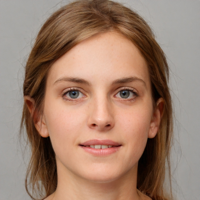

In [4]:
#Input visualization 
input_image = Image.open(BytesIO(requests.get(san_francisco_image_path).content))
input_image = input_image.resize((image_size,image_size))
input_image.save(input_image_path)
input_image

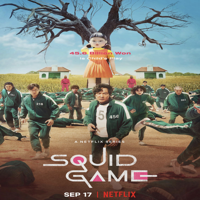

In [5]:
# Style visualization 
style_image = Image.open(BytesIO(requests.get(tytus_image_path).content))
style_image = style_image.resize((image_size,image_size))
style_image.save(style_image_path)
style_image

In [6]:
# Data normalization and reshaping from RGB to BGR
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= imagenet_mean_rgb_values[2]
input_image_array[:, :, :, 1] -= imagenet_mean_rgb_values[1]
input_image_array[:, :, :, 2] -= imagenet_mean_rgb_values[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= imagenet_mean_rgb_values[2]
style_image_array[:, :, :, 1] -= imagenet_mean_rgb_values[1]
style_image_array[:, :, :, 2] -= imagenet_mean_rgb_values[0]
style_image_array = style_image_array[:, :, :, ::-1]

In [7]:
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, image_size, image_size, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

In [8]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss = loss + content_weight * content_loss(content_image_features,
                                      combination_features)

In [9]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [10]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = image_size * image_size
    return backend.sum(backend.square(style - combination)) / (4. * (channels ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (style_weigh / len(style_layers)) * style_loss

In [11]:
def total_variation_loss(x):
    a = backend.square(x[:, :image_size-1, :image_size-1, :] - x[:, 1:, :image_size-1, :])
    b = backend.square(x[:, :image_size-1, :image_size-1, :] - x[:, :image_size-1, 1:, :])
    return backend.sum(backend.pow(a + b, total_variation_loss_factor))

loss += total_variation_weight * total_variation_loss(combination_image)

In [12]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, image_size, image_size, channels))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, image_size, image_size, 3)) - 128.

for i in range(iterations):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((image_size, image_size, channels))
x = x[:, :, ::-1]
x[:, :, 0] += imagenet_mean_rgb_values[2]
x[:, :, 1] += imagenet_mean_rgb_values[1]
x[:, :, 2] += imagenet_mean_rgb_values[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

Iteration 0 completed with loss 60663103488
Iteration 1 completed with loss 33976358912
Iteration 2 completed with loss 26480941056


In [ ]:
# Visualizing combined results
combined = Image.new("RGB", (image_size*3, image_size))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += image_size
combined.save(combined_image_path)
combined